In [1]:
# !pip install --quiet langchain-community 
# !pip install --quiet langchain-experimental langchain-openai 
# !pip install --quiet graphdatascience tiktoken retry neo4j
# !pip install --quiet matplotlib pandas numpy seaborn

## Graph RAG using Neo4j and Graph Datascience library

Graph-based Retrieval-Augmented Generation (RAG) models offer several advantages over traditional vector-based RAG models, particularly in contexts where the relationships between data points are complex and highly interconnected. Here's why graph RAG might be considered better than vector RAG in certain scenarios:
- **Richer Contextual Understanding**: Graph RAG can leverage the rich, interconnected structure of the graph
- **Dynamic Data Handling**: In scenarios where relationships change often, graphs can quickly adapt and provide latest information without re-indexing.
- **Complex Query capability**: Graph rag systems can handle complex queries that involve multiple hops or relationships. When combined with graph algorithms they can provide rich abstractions at various levels / groups of nodes. 
- **Efficiency in Sparse Data Environments**: In environments where relationships between the data is more important than the data itself, Graph RAG can be more efficient
- **Improved Interpretability**: The structural nature of the graph offers better interpretability of the decisions taken by the model to return certain nodes / relationships. In vector graphs, why a particular chunk is retrevied can be vague or difficult to interpret at times.
- **Scalability**: Knowledge graphs are well suited for large-scale knowledge stores. 

In this notebook we will be implementing Graph RAG on unstructured text using Neo4j (Desktop), Azure Open AI, Neo4j graph datascience library (for similarity, kmeans clustering).

In [12]:
import os
import pandas as pd
import tiktoken
from langchain_community.graphs import Neo4jGraph
from tqdm import tqdm
import numpy as np
import re

pd.set_option('display.max_columns', None)

In [13]:
os.environ["NEO4J_URI"] = "bolt://localhost:7687"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "Password@123"
graph = Neo4jGraph()

Here we will be using LLMs to extract entities and relationships from the text. LLMs can extract efficiently if the text follows a subject, predicate, object syntax and it is more suitable for unstructured documents that contain real world entities, relationships, organizations, names etc. 

In [4]:
# Here we will be using flipkart_product.csv file which contains the data of products from flipkart
# the file can be downloaded from the following link
# Link : https://www.kaggle.com/datasets/mansithummar67/flipkart-product-review-dataset
data = pd.read_csv("flipkart_product.csv", encoding="latin1")
# remove special characters from ProductName
# Using regex to replace all special characters with a space
spl_chars = '[!@#$%^&*()\[\]{};:,./<>?\|`~\-=_+]'
data["ProductName"] = data["ProductName"].apply(lambda x: re.sub(spl_chars, ' ', x))
data["Price"] = data["Price"].apply(lambda x: re.sub(spl_chars, ' ', str(x)))
data["Summary"] = data["Summary"].apply(lambda x: re.sub(spl_chars, ' ', str(x)))
# extract number from price
data["Price"] = data["Price"].apply(lambda x: re.findall(r'\d+', x))
data.head()

,ProductName,Price,Rate,Review,Summary
0,Candes 12 L Room Personal Air Cooler ÿ ÿ White...,"[3, 999]",5,Super!,Great cooler excellent air flow and for this...
1,Candes 12 L Room Personal Air Cooler ÿ ÿ White...,"[3, 999]",5,Awesome,Best budget 2 fit cooler Nice cooling
2,Candes 12 L Room Personal Air Cooler ÿ ÿ White...,"[3, 999]",3,Fair,The quality is good but the power of air is de...
3,Candes 12 L Room Personal Air Cooler ÿ ÿ White...,"[3, 999]",1,Useless product,Very bad product it's a only a fan
4,Candes 12 L Room Personal Air Cooler ÿ ÿ White...,"[3, 999]",3,Fair,Ok ok product


In [6]:
def get_token_count(text, model='gpt-4o'):
    encoding = tiktoken.encoding_for_model(model)
    num_tokens = len(encoding.encode(text))
    return num_tokens
data['token_count'] = [get_token_count(f"{row['ProductName']} {row['Summary']}") for i, row in data.iterrows()]

<Axes: title={'center': 'Token Count Distribution'}, xlabel='Token Count', ylabel='Frequency'>

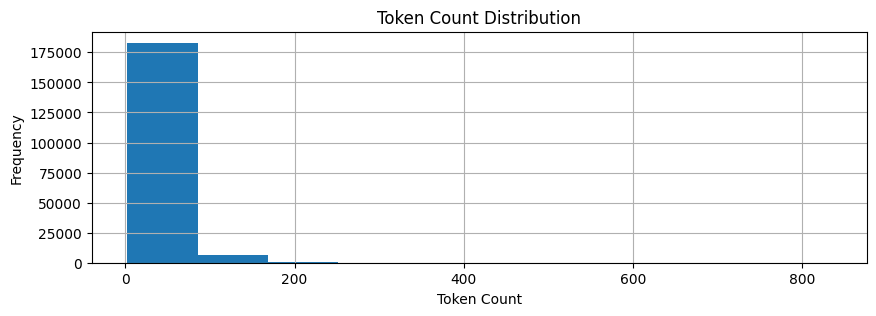

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.title("Token Count Distribution")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
data['token_count'].hist()

Most of the reviews have less than 100 words, hence further splitting is not required. If the text length is too long, the LLMs may not be able to extract all the entities / relationships. In such cases it is suggested to split the text into multiple chunks. 

In [8]:
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_community.graphs.graph_document import GraphDocument
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage
from langchain_openai import AzureChatOpenAI

os.environ["AZURE_OPENAI_API_KEY"] = "533894d8f28d4f238f10c0a51a46789e"
os.environ["AZURE_OPENAI_ENDPOINT"] = "https://sriks-openai.openai.azure.com/"
os.environ["AZURE_OPENAI_API_VERSION"] = "2024-05-01-preview"
os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT"] = "gpt-4o"

llm = AzureChatOpenAI(
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
    azure_deployment=os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT"],
)

llm_transformer = LLMGraphTransformer(
    llm=llm,
    node_properties=["description"],
    relationship_properties=["description"]
)     

Extract the entities, relationships from text and create graph

In [9]:
import random
random.seed(42)
# take 25 random rows
ids = random.sample(range(1, len(data)-1), 25)
data = data.iloc[ids]
data.head()

,ProductName,Price,Rate,Review,Summary,token_count
167622,cello Pack of 18 Opalware Cello Dazzle Lush Fi...,"[1, 299]",5,Just wow!,Just wow,39
29185,LA VERNE Microfibre Stripes Cushion Pack of 3Â...,[379],5,Fabulous!,Size is as expected and itâs good quality,31
6557,Cosito 144 TC Cotton Double Floral Flat Bedshe...,[339],4,Very Good,Very good,26
72098,JustandKrafts 75 L Blue Laundry BasketÂ Â Cot...,[298],1,Very poor,Poor product,18
64197,HAIR CARE Triple Blend Damage Repair Non Sti...,[113],5,Wonderful,Really good,38


In [11]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

graph_documents = []
# Convert each row to a Graph Document
# this will take some time 50 rows = 50*3 = 150 requests
# this may fail if token limit is reached

# TODO: Apply domain ontology to extract entities and relationships
with ThreadPoolExecutor(max_workers=2) as executor:
    futures = [executor.submit(llm_transformer.convert_to_graph_documents, [Document(page_content=f"""You are a data processing assistant, your task is to extract entities, relationships and their labels from product reviews. 
                                                                                     {row['ProductName'], row['Price'], row['Rate']} Review:{row['Review']} Summary:{row['Summary']}. 
                                                                                     """)]) for i, row in data.iterrows()]
    for future in tqdm(as_completed(futures), total=len(futures), desc="Converting to Graph Documents"):
        graph_documents.extend(future.result())
        

Converting to Graph Documents: 100%|██████████| 25/25 [03:21<00:00,  8.06s/it]


In [14]:
# creating graph docs will take time hence saving it to pickle file to load from it in future
# save graph docs to pickle file
import pickle
with open('graph_documents.pkl', 'wb') as f:
    pickle.dump(graph_documents, f)

In [15]:
graph_documents = pickle.load(open('graph_documents.pkl', 'rb'))

In [16]:
graph.add_graph_documents(
    graph_documents,
    baseEntityLabel=True,
    include_source=True
)

The initial structure of the graph looks segmented. 

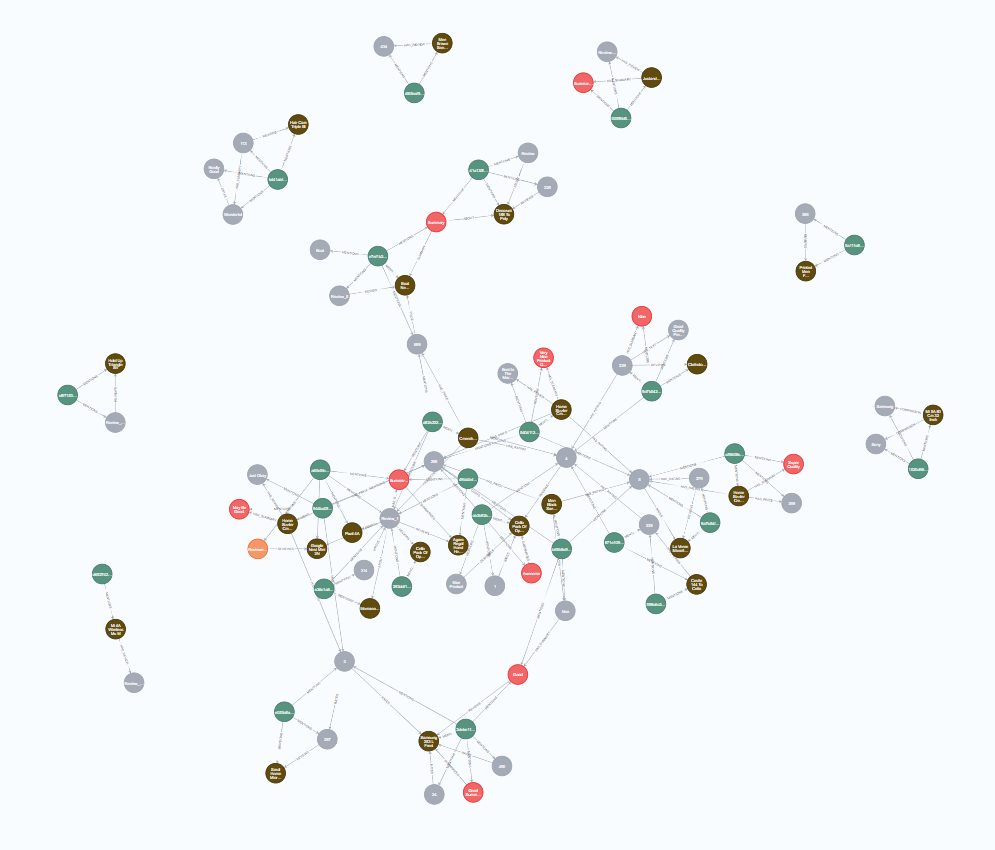

Generate embeddings for the extracted entities

In [17]:

from langchain_community.vectorstores import Neo4jVector
from langchain_openai import AzureOpenAIEmbeddings

# Create a vector store from the existing graph
vector = Neo4jVector.from_existing_graph(
        AzureOpenAIEmbeddings(),
        node_label='__Entity__',
        text_node_properties=['id', 'description'],
        embedding_node_property='embedding'
)

In [18]:
from graphdatascience import GraphDataScience

# Create a GraphDataScience instance
# GDS plugin must be installed in the Neo4j instance
gds = GraphDataScience(
    os.environ["NEO4J_URI"],
    auth=(os.environ["NEO4J_USERNAME"], os.environ["NEO4J_PASSWORD"])
)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('serverLocation' returned by 'gds.debug.arrow' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: 'CALL gds.debug.arrow()'
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('advertisedListenAddress' returned by 'gds.debug.arrow' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: 'CALL gds.debug.arrow()'


In [19]:
similrity_threshold = 0.95
gds.graph.drop("entities")
# exclude the score property from the graph
G, result = gds.graph.project(
    "entities", 
    "__Entity__",
    "*",
    nodeProperties=["embedding"],
    )   

# mutating the graph to add similar relationships

result = gds.knn.mutate(
    G,
    nodeProperties=["embedding"],
    nodeLabels = ["__Entity__"],
    mutateRelationshipType="SIMILAR",
    mutateProperty="score",
    similarityCutoff=similrity_threshold,
)
result.similarityDistribution    
print(result)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: 'CALL gds.graph.drop($graph_name, $fail_if_missing, $db_name)'


ranIterations                                                             4
nodePairsConsidered                                                   18387
didConverge                                                            True
preProcessingMillis                                                       0
computeMillis                                                            73
mutateMillis                                                             34
postProcessingMillis                                                      0
nodesCompared                                                            70
relationshipsWritten                                                    283
similarityDistribution    {'min': 0.9501724243164062, 'p5': 0.9509086608...
configuration             {'mutateProperty': 'score', 'jobId': 'af9d8562...
Name: 0, dtype: object


In [21]:
# writing the graph back to the database
result = gds.knn.write(
    G,
    nodeProperties=["embedding"],
    writeRelationshipType="SIMILAR",
    writeProperty="score",
    similarityCutoff=similrity_threshold,
)
print(f"Number of relationships created: {result.relationshipsWritten}")
print(result)

Number of relationships created: 283
ranIterations                                                             5
didConverge                                                            True
nodePairsConsidered                                                   19539
preProcessingMillis                                                       0
computeMillis                                                           104
writeMillis                                                              26
postProcessingMillis                                                      0
nodesCompared                                                            70
relationshipsWritten                                                    283
similarityDistribution    {'min': 0.9501724243164062, 'p5': 0.9509086608...
configuration             {'writeProperty': 'score', 'writeRelationshipT...
Name: 0, dtype: object


In [22]:
# get nodes with relationtype as SIMILAR
query = """
MATCH (n:__Entity__)-[r:SIMILAR]-(m:__Entity__)
RETURN n.id as node1, m.id as node2, r.score as score
"""
result = pd.DataFrame.from_records(gds.run_cypher(query))
# exclude numeric types from node 1 and 2
result = result[~result['node1'].str.contains(r'\d')]
result.head()

C:\Users\vism\AppData\Local\Temp\ipykernel_27768\2281118004.py:6: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  result = pd.DataFrame.from_records(gds.run_cypher(query))


,node1,node2,score
0,Good Quality Product,Very Nice Product Don'T Think Much Go For Itð...,0.950907
1,Nice Product,Very Nice Product Don'T Think Much Go For Itð...,0.963699
2,Nice Product,Very Nice Product Don'T Think Much Go For Itð...,0.963699
3,Good Quality Product,Very Nice Product Don'T Think Much Go For Itð...,0.950907
4,Nice Product,Very Nice Product Don'T Think Much Go For Itð...,0.963699


Find similar entities by Levenshtein distance

In [23]:
import Levenshtein

edit_distance_threshold = 4
query = """
MATCH (n:__Entity__)
RETURN n.id as id, n.wcc as wcc
"""
entities_df = pd.DataFrame.from_records(graph.query(query))
print(f"Number of entities: {entities_df.shape[0]}")
edit_distances = pd.crosstab(entities_df['id'], entities_df['id'])
# fill values with edit distance between column and row names
for i in edit_distances.columns:
    for j in edit_distances.index:
        if len(i) > 4 and len(j) > 4:
            # if i or j has "innings" in it, skip
            edit_distances.loc[j, i] = Levenshtein.distance(i, j)
# find edit distances below threshold and greater than 0
edit_distances = edit_distances[(edit_distances < edit_distance_threshold)]
# create a dictionary of similar entities
edit_distances = edit_distances[edit_distances > 1].stack().to_dict()
edit_distances

Number of entities: 70


{('Review', 'Review_1'): 2.0,
 ('Review', 'Review_5'): 2.0,
 ('Review_1', 'Review'): 2.0,
 ('Review_1', 'Review_136'): 2.0,
 ('Review_1', 'Reviewer_1'): 2.0,
 ('Review_136', 'Review_1'): 2.0,
 ('Review_136', 'Review_1_565'): 3.0,
 ('Review_136', 'Review_5'): 3.0,
 ('Review_1_565', 'Review_136'): 3.0,
 ('Review_5', 'Review'): 2.0,
 ('Review_5', 'Review_136'): 3.0,
 ('Review_5', 'Reviewer_1'): 3.0,
 ('Reviewer_1', 'Review_1'): 2.0,
 ('Reviewer_1', 'Review_5'): 3.0,
 ('Summary', 'Summary_1'): 2.0,
 ('Summary_1', 'Summary'): 2.0}

Merge Entities with low edit distance

In [24]:
for key, value in edit_distances.items():
    if key[0] != key[1]:
        # merge nodes using  apoc.refactor.mergeNodes(nodes)
        print(f"Merging Nodes {key[0]} and {key[1]} with score {value}")
        merge_query = f"""
        MATCH (n:__Entity__), (m:__Entity__)
        WHERE n.id = '{key[0]}' AND m.id = '{key[1]}' AND n <> m
        CALL apoc.refactor.mergeNodes([n, m]) YIELD node
        RETURN node
        """
        graph.query(merge_query)

Merging Nodes Review and Review_1 with score 2.0
Merging Nodes Review and Review_5 with score 2.0
Merging Nodes Review_1 and Review with score 2.0
Merging Nodes Review_1 and Review_136 with score 2.0
Merging Nodes Review_1 and Reviewer_1 with score 2.0
Merging Nodes Review_136 and Review_1 with score 2.0
Merging Nodes Review_136 and Review_1_565 with score 3.0
Merging Nodes Review_136 and Review_5 with score 3.0
Merging Nodes Review_1_565 and Review_136 with score 3.0
Merging Nodes Review_5 and Review with score 2.0
Merging Nodes Review_5 and Review_136 with score 3.0
Merging Nodes Review_5 and Reviewer_1 with score 3.0
Merging Nodes Reviewer_1 and Review_1 with score 2.0
Merging Nodes Reviewer_1 and Review_5 with score 3.0
Merging Nodes Summary and Summary_1 with score 2.0
Merging Nodes Summary_1 and Summary with score 2.0


In [25]:
G.drop()

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: 'CALL gds.graph.drop($graph_name, $failIfMissing)'


graphName                                                         entities
database                                                             neo4j
databaseLocation                                                     local
memoryUsage                                                               
sizeInBytes                                                             -1
nodeCount                                                               70
relationshipCount                                                      348
configuration            {'relationshipProjection': {'__ALL__': {'aggre...
density                                                            0.07205
creationTime                           2024-07-16T12:39:21.614203800+00:00
modificationTime                       2024-07-16T12:39:21.826041200+00:00
schema                   {'graphProperties': {}, 'nodes': {'__Entity__'...
schemaWithOrientation    {'graphProperties': {}, 'nodes': {'__Entity__'...
Name: 0, dtype: object

## Identify Graph communities and enhance the knowledge using LLM

In this section we will be using KMEANS supervised machine learning algorithm which is already part of Graph Data science library to find clusters in the graph. 
This approach is slightly different from the paper https://www.microsoft.com/en-us/research/publication/from-local-to-global-a-graph-rag-approach-to-query-focused-summarization/
In the above paper the authors use Lieden algorithm for finding hierarchical clusters. In this notebook we will follow a simple approach and use KMEANS. 
For other community identification algorithms supported by GDS please visit : https://neo4j.com/docs/graph-data-science/current/algorithms/community/

In [42]:
# # Project the graph to create a community graph
gds.graph.drop("communities")
node_properties = ["embedding"]
similarityCutoff = 0.97
topK = 5 # number of clusters to identify, the k in k-means

G, result = gds.graph.project(
    "communities",  #  Graph name
    "__Entity__",  #  Node projection
    "*",
    nodeProperties=node_properties,
)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: 'CALL gds.graph.drop($graph_name, $fail_if_missing, $db_name)'


In [43]:
gds.kmeans.stats(G,nodeProperty=node_properties[0],k=topK)

communityDistribution        {'min': 5, 'p5': 5, 'max': 28, 'p999': 28, 'p9...
centroids                    [[0.0030999169684946537, 0.003698816057294607,...
averageDistanceToCentroid                                             0.359274
averageSilhouette                                                          0.0
postProcessingMillis                                                         1
preProcessingMillis                                                          0
computeMillis                                                                4
configuration                {'jobId': '3c87063b-a963-422c-a2ea-e68dd36c134...
Name: 0, dtype: object

In [44]:
gds.kmeans.mutate(
    G,
    nodeProperty = node_properties[0],
    mutateProperty = "community",
    k = topK,
)

# Mutate runs the algorithm in memory, it is good for debugging, chaining algorithms, and testing

mutateMillis                                                                 0
nodePropertiesWritten                                                       65
communityDistribution        {'min': 2, 'p5': 2, 'max': 30, 'p999': 30, 'p9...
centroids                    [[-0.0048058717511594296, -0.00306518445722758...
averageDistanceToCentroid                                             0.363949
averageSilhouette                                                          0.0
postProcessingMillis                                                         9
preProcessingMillis                                                          0
computeMillis                                                               16
configuration                {'mutateProperty': 'community', 'jobId': '3352...
Name: 0, dtype: object

In [33]:
gds.kmeans.write(
    G,
    nodeProperty = node_properties[0],
    writeProperty = "community",
    k = topK,
)

writeMillis                                                                 14
nodePropertiesWritten                                                       65
communityDistribution        {'min': 4, 'p5': 4, 'max': 22, 'p999': 22, 'p9...
centroids                    [[0.0005631918902508914, -0.00246163341216743,...
averageDistanceToCentroid                                              0.35878
averageSilhouette                                                          0.0
postProcessingMillis                                                        18
preProcessingMillis                                                          0
computeMillis                                                               12
configuration                {'writeProperty': 'community', 'jobId': '0a0e3...
Name: 0, dtype: object

In [47]:
# get nodes with writeProperty as community
query = """
MATCH (n:__Entity__)
RETURN n.id as id, n.community as community
"""
result = pd.DataFrame.from_records(gds.run_cypher(query))
result['count'] = result.groupby("community")["id"].transform("count")
result["entities"] = result.groupby("community")["id"].transform(lambda x: ", ".join(x))
# drop id column
result = result.drop(columns=["id"])
result = result.drop_duplicates()
# get the top 5 communities
result.head().sort_values(by="count", ascending=False)

C:\Users\vism\AppData\Local\Temp\ipykernel_27768\1492483429.py:6: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  result = pd.DataFrame.from_records(gds.run_cypher(query))


,community,count,entities
0,2,22,"Best In The Market!, Very Nice Product Don'T T..."
3,1,18,"24, 490, 3, 379, 5, 4, 399, 386, 329, 229, 113..."
10,4,14,La Verne Microfibre Stripes Cushion Pack Of 3 ...
9,0,7,Cello Pack Of 18 Opalware Cello Dazzle Lush Fi...
14,3,4,"339, Review_1_565, Review:Very Poor, Reviewer_1"


In [49]:
# Lets see the top 5 entities in each community to understand the entities in each community
# We should witness similar entities in each community
print(result.iloc[0].entities.split(", ")[:5]) 
print(result.iloc[1].entities.split(", ")[:5]) 
print(result.iloc[2].entities.split(", ")[:5]) 

['Best In The Market!', "Very Nice Product Don'T Think Much Go For Itð\x9f\x91\x8dÐ\x9f\x8f»", 'Samsung 253 L Frost Free Double Door 3 Star Refrigerator Elegant Inox Rt28A3453S8 Hl', 'Good', 'Good Summary']
['24', '490', '3', '379', '5']
['Cello Pack Of 18 Opalware Cello Dazzle Lush Fiesta Opalware Dinner Set 18 Pieces Dinner Set White Microwave Safe', 'Home Sizzler 214 Cm 7 02 Ft Polyester Semi Transparent Door Curtain Pack Of 2 Â Floral Brown', 'Cmerchants Book Shelf 5Rack Metal Open Book Shelf', 'Home Sizzler 153 Cm  5 02 Ft  Polyester Room Darkening Window Curtain  Pack Of 2 Â Floral  Brown', 'Home Sizzler 153 Cm 5 02 Ft Polyester Room Darkening Window Curtain Pack Of 2 Floral Brown']


In [50]:
graph.query("CREATE CONSTRAINT IF NOT EXISTS FOR (c:__Community__) REQUIRE c.id IS UNIQUE;")

[]

In [51]:
# create a node for each community and create a relationship between community and entities
for i, row in result.iterrows():
    community_id = row["community"]
    entities = row["entities"].split(", ")
    query = f"""
    MERGE (c:__Community__{{id: '{community_id}'}})
    WITH c
    UNWIND {entities} as entity
    MATCH (n:__Entity__{{id: entity }})
    MERGE (n)-[:BELONGS_TO]->(c)
    """
    result = graph.query(query)
    print(f"Community {community_id} created with {len(entities)} entities")

Community 2 created with 22 entities
Community 1 created with 18 entities
Community 0 created with 7 entities
Community 4 created with 14 entities
Community 3 created with 4 entities


In [52]:
# create summaries for each community
query = """
    MATCH (n:__Entity__)-[:BELONGS_TO]->(c:__Community__)
    with c, collect(n) as nodes
    where size(nodes) > 1
    call apoc.path.subgraphAll(nodes, {limit: 2}) 
    YIELD relationships as rels
    RETURN c.id as community_id
    , 
    [n in nodes | {id: n.id, description: n.description, type: [el in labels(n) where el <> '__Entity__'][0]}] as nodes,
    [r in rels | {start: startNode(r).id, end: endNode(r).id, type: type(r), description: r.description}] as relationships
    """
result = graph.query(query)
print(result[0])

{'community_id': '2', 'nodes': [{'id': 'Samsung 253 L Frost Free Double Door 3 Star Refrigerator Elegant Inox Rt28A3453S8 Hl', 'description': 'SAMSUNG 253 L Frost Free Double Door 3 Star Refrigerator Elegant Inox RT28A3453S8 HL', 'type': 'Product'}, {'id': 'Nice', 'description': None, 'type': 'Summary'}, {'id': 'Good Quality Product', 'description': None, 'type': 'Review_text'}, {'id': 'Wonderful', 'description': None, 'type': 'Reviewsummary'}, {'id': 'Good Summary', 'description': None, 'type': 'Summary'}, {'id': 'Summary_1', 'description': 'Useless product', 'type': 'Summary'}, {'id': 'Sony', 'description': None, 'type': 'Brand'}, {'id': '434', 'description': "It's synthetic leather gets off when any water spell on it Very bad product don't purchase do buy by looking picture it's waste of money and time.", 'type': 'Review'}, {'id': 'Agaro Regal Hand Held Vacuum Cleaner Black', 'description': None, 'type': 'Product'}, {'id': 'Good', 'description': None, 'type': 'Review'}, {'id': 'Sams

In [53]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

def get_summary_llm():
    prompt = """Based on the provided nodes and relationships that belong to the same graph community,
generate a natural language summary of the provided information:{community_info} Summary:"""
    community_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Given an input triples, generate the information summary. No pre-amble.",
        ),
        ("human", prompt),
    ])
    community_chain = community_prompt | llm | StrOutputParser()
    return community_chain

community_summaries = {}
for community in result:
    nodes = community["nodes"]
    relationships = community["relationships"]
    community_info = ""
    for node in nodes:
        community_info += f"{node['id']} is a {node['type']} with description {node['description']}. "
    chain = get_summary_llm()
    summary = chain.invoke({'community_info': community_info})
    community_summaries[community["community_id"]] = summary

In [54]:
community_summaries

{'2': 'The provided information covers various products, brands, reviews, and summaries. The primary focus is on different products from brands like Samsung and Sony. For instance, the "Samsung 253 L Frost Free Double Door 3 Star Refrigerator Elegant Inox Rt28A3453S8 Hl" is highlighted with a detailed description. Reviews and summaries range widely in sentiment, indicating mixed feedback. Products like the "Agaro Regal Hand Held Vacuum Cleaner Black" and "Mi 5A 80 Cm 32 Inch Hd Ready Led Smart Android Tv With Dolby Audio 2022 Model" are mentioned without detailed descriptions. User reviews include specific complaints, such as the negative feedback on a product described as having synthetic leather that degrades with water exposure. Positive reviews include terms like "Best In The Market!" and "Nice Product," while more critical summaries describe items as "Useless product" and "Poor Product." The brand Samsung appears multiple times, suggesting a focus on their products. Overall, the i

In [55]:
# merge the summary to the community node
for community_id, summary in community_summaries.items():
    query = """
    MATCH (c:__Community__{id:$community_id})
    SET c.summary = $summary
    """
    result = graph.query(query, params={"community_id": community_id, "summary": summary})
    print(f"Summary added to Community {community_id}")

Summary added to Community 2
Summary added to Community 1
Summary added to Community 0
Summary added to Community 4
Summary added to Community 3


## Run LLM Queries on graph

In [56]:
index_name = "document_embeddings"  # index name
# Create a vector store from the existing graph
graph = Neo4jVector.from_existing_graph(
    AzureOpenAIEmbeddings(),
    node_label='__Entity__',
    text_node_properties=['id', 'description', 'summary', 'community'],
    embedding_node_property='embedding',
    index_name=index_name,
)

In [57]:
def get_product(query):
   meta = "Given user query: {query} return nodes with similar embeddings, community and id"
   docs_with_score = graph.similarity_search_with_score(query, k=4)
   # get the community and id of the nodes
   # TODO: find a generic way to parse
   product = docs_with_score[0][0].page_content.split("\n")[1]
   product = product.split(":")[1].strip()
   print(product)
   return product

In [72]:
# get similar products and corresponding reviews relationships
def get_content_by_rel(product):
    query = """
    MATCH (product:__Entity__{id: $product})
    with product
    match (product)-[:SIMILAR]-(similar:__Entity__)
    with product, collect(similar) AS similarEntities
    unwind similarEntities AS similarEntity
    MATCH (similarEntity)-[r:HAS_REVIEW]->(review:Review)
    WITH product, similarEntities, similarEntity, collect({start: similarEntity.id, end: review.id, type: type(r), value: review.description}) AS relationships, 
    collect({product: product.id, similar: similarEntity.id, review: review.description}) AS reviews
    RETURN 
    {id: product.id, description: product.description, type: [label IN labels(product) WHERE label <> '__Entity__'][0]} AS productDetails, reviews,
    [entity IN similarEntities | {id: entity.id, description: entity.description, type: [label IN labels(entity) WHERE label <> '__Entity__'][0]}] AS nodes,
    relationships    
    """
    result = graph.query(query, params={"product": product})
    print(result)
    return result

# get_content_by_rel("Home Sizzler 214 Cm 7 02 Ft Polyester Semi Transparent Door Curtain Pack Of 2 Â Floral Brown")

In [71]:
import json
query = "recommend a good Door Curtain Pack"

def get_recommendation(query):
    product = get_product(query)
    nodes_relationships = get_content_by_rel(product)
    prompt = """Based on the provided context, provide a recommendation based on the provided information. 
    Use description and relationships to provide the recommendation.
    Context:{nodes_relationships}"""
    reco_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a data processing assistant, your task is to provide a recommendation based on the provided information. Be concise and to the point.",
            ),
            ("human", prompt),
        ]
    )
    template = reco_prompt | llm | StrOutputParser()
    result = template.invoke({"nodes_relationships": json.dumps(nodes_relationships)})
    return result
ans = get_recommendation(query)
print("="*50)
print(ans)


Home Sizzler 214 Cm 7 02 Ft Polyester Semi Transparent Door Curtain Pack Of 2 Â Floral Brown
[{'productDetails': {'id': 'Home Sizzler 214 Cm 7 02 Ft Polyester Semi Transparent Door Curtain Pack Of 2 Â Floral Brown', 'description': None, 'type': 'Product'}, 'reviews': [{'product': 'Home Sizzler 214 Cm 7 02 Ft Polyester Semi Transparent Door Curtain Pack Of 2 Â Floral Brown', 'review': None, 'similar': 'Home Sizzler 153 Cm 5 02 Ft Polyester Room Darkening Window Curtain Pack Of 2 Floral Brown'}, {'product': 'Home Sizzler 214 Cm 7 02 Ft Polyester Semi Transparent Door Curtain Pack Of 2 Â Floral Brown', 'review': None, 'similar': 'Home Sizzler 153 Cm 5 02 Ft Polyester Room Darkening Window Curtain Pack Of 2 Floral Brown'}, {'product': 'Home Sizzler 214 Cm 7 02 Ft Polyester Semi Transparent Door Curtain Pack Of 2 Â Floral Brown', 'review': None, 'similar': 'Home Sizzler 153 Cm 5 02 Ft Polyester Room Darkening Window Curtain Pack Of 2 Floral Brown'}, {'product': 'Home Sizzler 214 Cm 7 02 Ft 

Final Graph with Clusters (Big Yellow Circles), Semantic Relationships and Merged nodes.

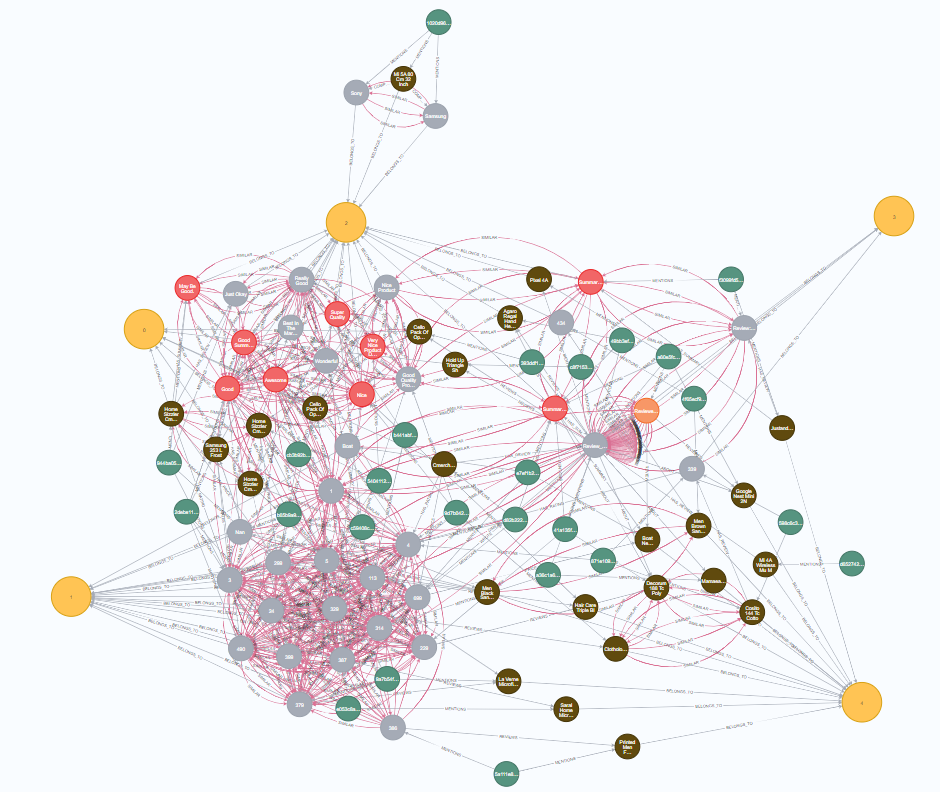